In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [42]:
# Adjust the path if needed
df = pd.read_csv("../data/BeijingPM20100101_20151231.csv", na_values=["NA", "NaN", "nan", "", " "])

# Combine year/month/day/hour into a single timestamp
df["datetime"] = pd.to_datetime(
    dict(year=df["year"], month=df["month"], day=df["day"], hour=df["hour"]),
    errors="coerce"
)

# Index by datetime
df = df.set_index("datetime").sort_index()

df.head(3)


,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
datetime,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
2010-01-01 01:00:00,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2010-01-01 02:00:00,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0


In [43]:
pm_cols = [c for c in df.columns if c.lower().startswith("pm")]
pm_cols


# Convert PM columns to numeric (coerce any weird strings to NaN)
df[pm_cols] = df[pm_cols].apply(pd.to_numeric, errors="coerce")

# Composite via row-wise mean (robust alternative: .median(axis=1, skipna=True))
pm25 = df[pm_cols].mean(axis=1, skipna=True)

pm25.head()



datetime
2010-01-01 00:00:00   NaN
2010-01-01 01:00:00   NaN
2010-01-01 02:00:00   NaN
2010-01-01 03:00:00   NaN
2010-01-01 04:00:00   NaN
dtype: float64

In [44]:
# PM2.5 cannot be <= 0; mark them as NaN
pm25 = pm25.where(pm25 > 0)

# Fill gaps: forward-fill then back-fill as a fallback
pm25 = pm25.ffill().bfill()

pm25.isna().sum(), pm25.describe()


(0,
 count    52584.000000
 mean        94.629788
 std         89.830622
 min          1.000000
 25%         27.000000
 50%         69.000000
 75%        131.500000
 max        994.000000
 dtype: float64)

In [45]:
daily = pm25.resample("D").mean()

# Fill any remaining small daily gaps
daily = daily.ffill().bfill()

daily.head(), daily.index.min(), daily.index.max()


(datetime
 2010-01-01    129.000000
 2010-01-02    144.333333
 2010-01-03     78.375000
 2010-01-04     29.291667
 2010-01-05     43.541667
 Freq: D, dtype: float64,
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2015-12-31 00:00:00'))

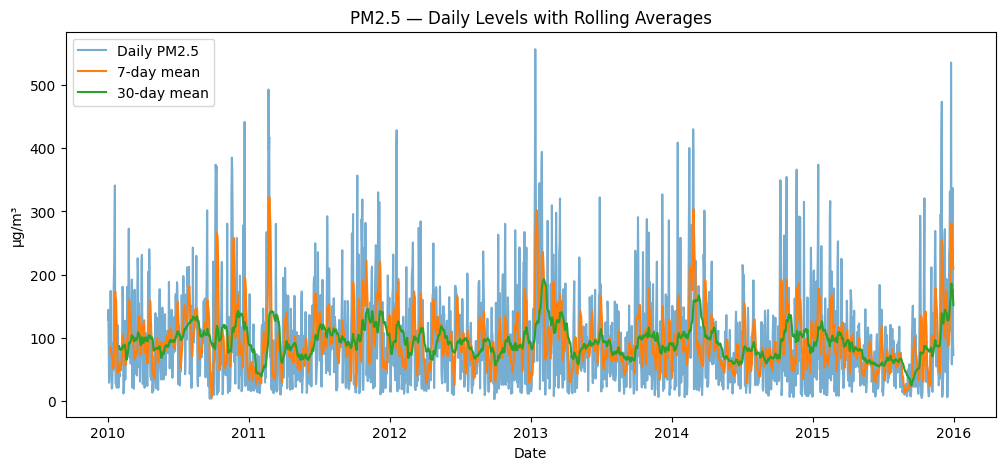

In [46]:
plt.figure(figsize=(12, 5))
plt.plot(daily, label="Daily PM2.5", alpha=0.6)
plt.plot(daily.rolling(7).mean(), label="7-day mean")
plt.plot(daily.rolling(30).mean(), label="30-day mean")
plt.legend()
plt.title("PM2.5 — Daily Levels with Rolling Averages")
plt.ylabel("µg/m³")
plt.xlabel("Date")
plt.show()


In [47]:
clean_daily = daily.rename("pm25").to_frame()
clean_daily.to_csv("../data/clean_pm25.csv", index=True)
clean_daily.head()

,pm25
datetime,
2010-01-01,129.000000
2010-01-02,144.333333
2010-01-03,78.375000
2010-01-04,29.291667
2010-01-05,43.541667


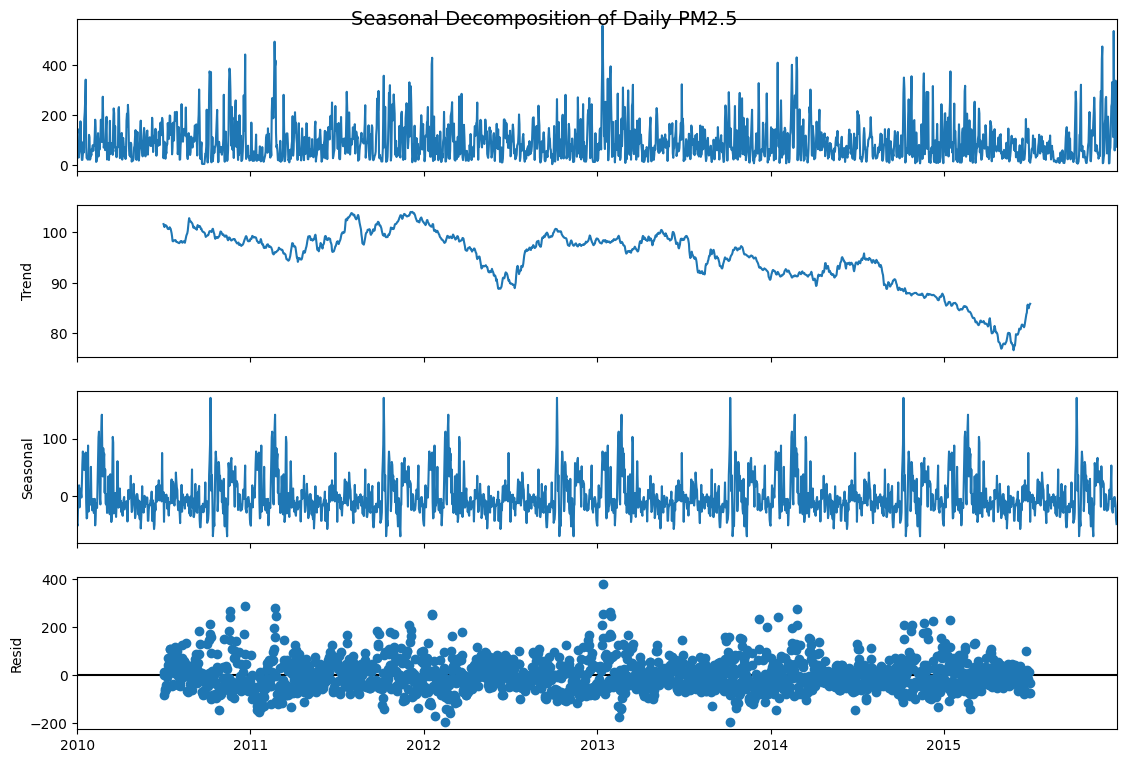

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(daily, model="additive", period=365)  # 365 days ≈ yearly seasonality

fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Seasonal Decomposition of Daily PM2.5", fontsize=14)
plt.show()


## Observation: The trend shows a clear decline from 2013–2015, suggesting improved air quality. The seasonal component peaks during winter months (likely due to heating) and drops in summer.



In [49]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily.dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic: -21.62263145979541
p-value: 0.0
Critical Value (1%): -3.4333422250634027
Critical Value (5%): -2.8628618662999394
Critical Value (10%): -2.567473694616472
